In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [91]:
# Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(64, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.gen(x)

In [92]:
# Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Flatten(),
            nn.Linear(256*3*3, 500),
            nn.LeakyReLU(0.1),
            nn.Linear(500, 100),
            nn.LeakyReLU(0.1),
            nn.Linear(100, 25),
            nn.LeakyReLU(0.1),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.disc(x)

In [93]:
class GAN(nn.Module):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()
        
    def forward(self, x):
        return self.discriminator(x)

In [94]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 3e-4
z_dim = 64
img_dim = 784
batch_size = 32
num_epochs = 50

In [95]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [96]:
# Initialize model
model = GAN().to(device)
opt_disc = optim.Adam(model.discriminator.parameters(), lr=lr)
opt_gen = optim.Adam(model.generator.parameters(), lr=lr)
criterion = nn.BCELoss()

In [97]:
counter = 0

def train(number_of_epochs):
    for epoch in range(number_of_epochs):
        global counter
        counter += 1
        
        for batch_idx, (real, _) in enumerate(dataloader):
            batch_size = real.shape[0]
            disc_real = model.discriminator(real).view(-1)
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            
            noise = torch.randn(batch_size, z_dim).to(device).view(batch_size, z_dim, 1, 1)
            fake = model.generator(noise)
            disc_fake = model.discriminator(fake).view(-1)
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            
            lossD = (lossD_real + lossD_fake)
            model.discriminator.zero_grad()
            lossD.backward(retain_graph=True)
            opt_disc.step()
                
               
            noise = torch.randn(batch_size, z_dim).to(device).view(batch_size, z_dim, 1, 1)
            fake = model.generator(noise)
            output = model.discriminator(fake).view(-1)
            lossG = criterion(output, torch.ones_like(output))
            # model.generator.zero_grad()
            model.zero_grad()
            lossG.backward()
            opt_gen.step()
            
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch}/{counter}], batch [{batch_idx}/{int(len(dataloader.dataset)/batch_size)}] Loss D: {lossD:.10f}, Loss G: {lossG:.10f}")
    
        print("=====================================================================================")
        print(f"Epoch [{epoch}/{num_epochs}] Loss D: {lossD:.10f}, Loss G: {lossG:.10f}")
        print("=====================================================================================")

In [98]:
def test_generate():
    noise = torch.randn(batch_size, z_dim).to(device).view(batch_size, z_dim, 1, 1)
    fake = model.generator(noise)
    fake = fake.view(-1, 28, 28).detach().cpu().numpy()
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(fake[i], cmap='gray')
        plt.axis('off')
    plt.show()

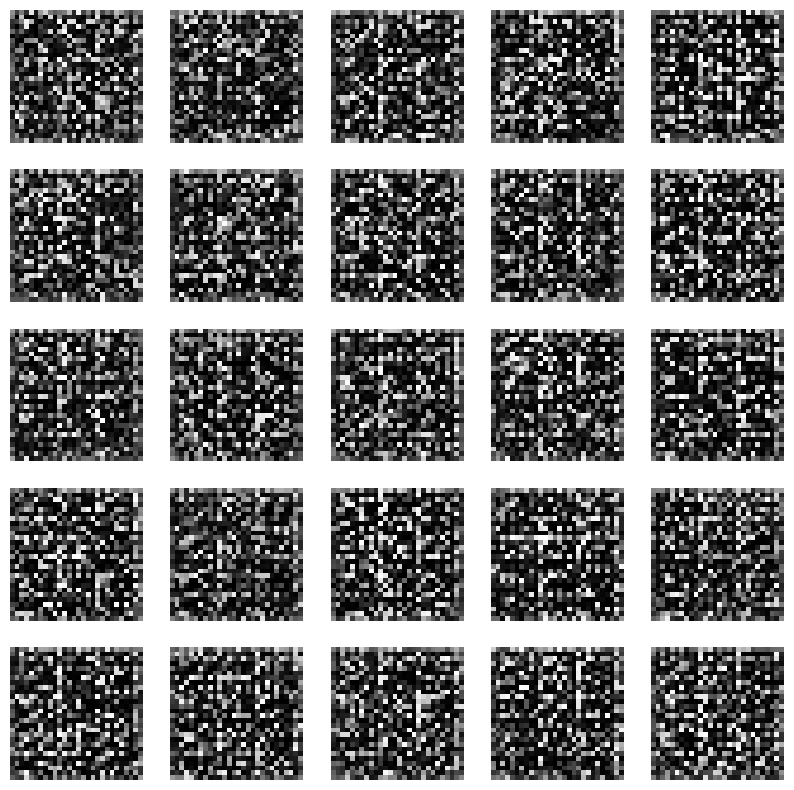

In [99]:
test_generate()

In [100]:
train(1)

Epoch [0/1], batch [0/1875] Loss D: 1.3932228088, Loss G: 0.6559892297
Epoch [0/1], batch [100/1875] Loss D: 0.0059458856, Loss G: 9.4075908661
Epoch [0/1], batch [200/1875] Loss D: 0.0070346668, Loss G: 6.9664306641
Epoch [0/1], batch [300/1875] Loss D: 0.0017630109, Loss G: 8.3005790710
Epoch [0/1], batch [400/1875] Loss D: 0.0180039965, Loss G: 7.4426984787
Epoch [0/1], batch [500/1875] Loss D: 0.0069313869, Loss G: 6.6931958199
Epoch [0/1], batch [600/1875] Loss D: 0.0651036948, Loss G: 6.8693790436
Epoch [0/1], batch [700/1875] Loss D: 0.0033263424, Loss G: 6.9753327370
Epoch [0/1], batch [800/1875] Loss D: 0.1307412982, Loss G: 4.7344446182
Epoch [0/1], batch [900/1875] Loss D: 0.0182628948, Loss G: 8.4955816269
Epoch [0/1], batch [1000/1875] Loss D: 0.0097056124, Loss G: 8.2714214325
Epoch [0/1], batch [1100/1875] Loss D: 0.0018438514, Loss G: 8.7069425583
Epoch [0/1], batch [1200/1875] Loss D: 0.0067020706, Loss G: 11.2507133484
Epoch [0/1], batch [1300/1875] Loss D: 0.13560685

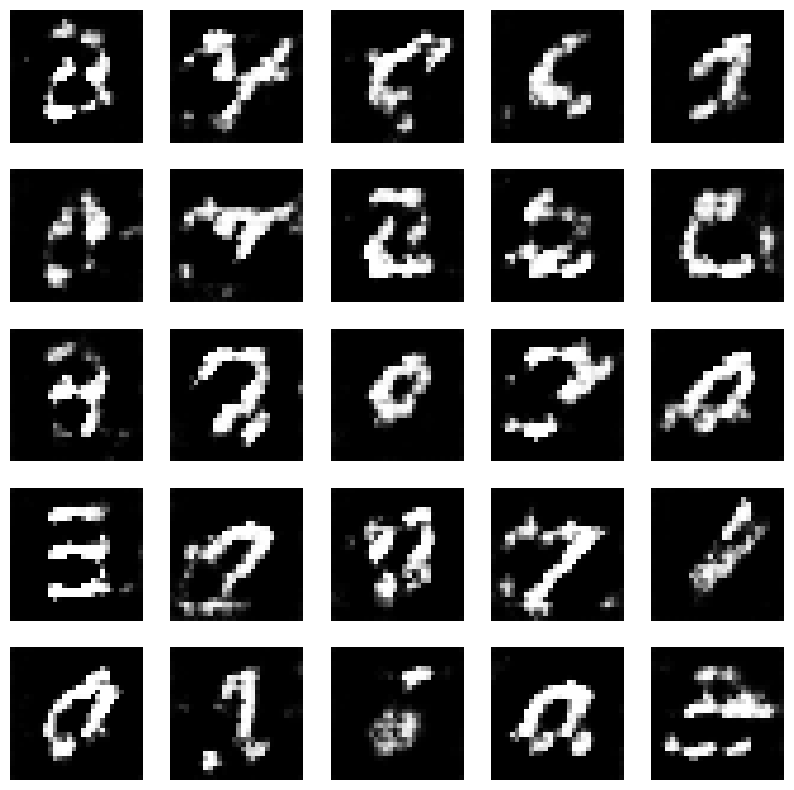

In [101]:
test_generate()

In [102]:
train(1)

Epoch [0/2], batch [0/1875] Loss D: 0.0770925656, Loss G: 4.4087553024
Epoch [0/2], batch [100/1875] Loss D: 0.4981557727, Loss G: 5.4693784714
Epoch [0/2], batch [200/1875] Loss D: 0.1845149398, Loss G: 3.9042413235
Epoch [0/2], batch [300/1875] Loss D: 0.2286380529, Loss G: 4.9371376038
Epoch [0/2], batch [400/1875] Loss D: 0.3370014727, Loss G: 3.8954448700
Epoch [0/2], batch [500/1875] Loss D: 0.3339512050, Loss G: 3.4090585709
Epoch [0/2], batch [600/1875] Loss D: 0.2563654184, Loss G: 3.3865191936
Epoch [0/2], batch [700/1875] Loss D: 0.4084132016, Loss G: 4.2154440880
Epoch [0/2], batch [800/1875] Loss D: 0.2434165180, Loss G: 5.8035149574
Epoch [0/2], batch [900/1875] Loss D: 0.1789534837, Loss G: 4.0448613167
Epoch [0/2], batch [1000/1875] Loss D: 0.3463355005, Loss G: 4.5370492935
Epoch [0/2], batch [1100/1875] Loss D: 0.7505922318, Loss G: 4.1083784103
Epoch [0/2], batch [1200/1875] Loss D: 0.2593559921, Loss G: 2.4836170673
Epoch [0/2], batch [1300/1875] Loss D: 0.235657915

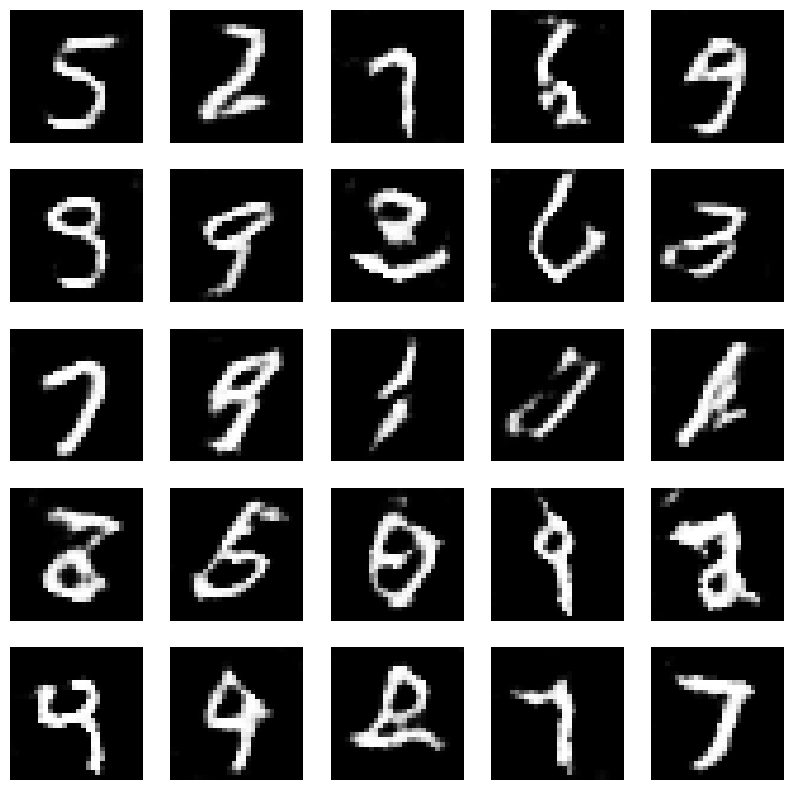

In [103]:
test_generate()

In [ ]:
train(1)

Epoch [0/3], batch [0/1875] Loss D: 0.3225673139, Loss G: 3.0686578751
Epoch [0/3], batch [100/1875] Loss D: 0.4235443473, Loss G: 3.5351078510
Epoch [0/3], batch [200/1875] Loss D: 0.4841251075, Loss G: 6.0532159805
Epoch [0/3], batch [300/1875] Loss D: 0.1992436349, Loss G: 5.7687501907
Epoch [0/3], batch [400/1875] Loss D: 0.1838177145, Loss G: 5.3734703064
Epoch [0/3], batch [500/1875] Loss D: 0.4701638818, Loss G: 4.2987647057
Epoch [0/3], batch [600/1875] Loss D: 0.2464721203, Loss G: 3.1892182827
Epoch [0/3], batch [700/1875] Loss D: 0.4530599117, Loss G: 2.9856636524
Epoch [0/3], batch [800/1875] Loss D: 0.0597572327, Loss G: 3.7037227154
Epoch [0/3], batch [900/1875] Loss D: 0.1482491344, Loss G: 5.5991210938
Epoch [0/3], batch [1000/1875] Loss D: 1.0252486467, Loss G: 3.2475578785
Epoch [0/3], batch [1100/1875] Loss D: 0.7201699018, Loss G: 1.9571472406
Epoch [0/3], batch [1200/1875] Loss D: 0.1997725517, Loss G: 6.1017003059
Epoch [0/3], batch [1300/1875] Loss D: 0.145172774

In [ ]:
test_generate()